In [1]:
# Pkg.add(["Polynomials", "PyPlot"]) uncomment to install if needed
using Polynomials, PyPlot

# Dot products of functions

We can apply the Gram–Schmidt process to *any* vector space as long as we **define a dot product** (also called an **inner product**).   (Technically, a continuous ("complete") vector space equipped with an inner product is called a **Hilbert space**.)

For column vectors, the usual dot product is to multiply the components and add them up.

But (real-valued) *functions* $f(x)$ also define a vector space (you can add, subtract, and multiply by constants).  In particular, consider functions defined on the interval $x \in [-1,1]$.   The "components" of $f$ can be viewed as its *values* $f(x)$ at each point in the domain, and the obvious analogue of "summing the components" is the **integral**.   Hence, the most obvious "dot product" of two functions in this space is:

$$
f \cdot g = \int_0^1 f(x) g(x) \, dx
$$

Such a generalized inner product is commonly denoted $\langle f, g \rangle$ (or $\langle f | g \rangle$ in physics).

# Orthogonal polynomials

In particular, let us consider a subspace of functions defined on $[-1,1]$: **polynomials** $p(x)$ (of any degree).

One possible basis of polynomials is simply:

$$
{1, x, x^2, x^3, \ldots}
$$

(There are infinitely many polynomials in this basis because this vector space is **infinite-dimensional**.)

Instead, let us apply Gram–Schmidt to this basis in order to get an **orthogonal basis of polynomials** known as the [Legendre polynomials](https://en.wikipedia.org/wiki/Legendre_polynomials).

## Julia code

I'll use the [Polynomials package](https://github.com/Keno/Polynomials.jl) to do polynomial arithmetic for me.

However, I'll need to define a few extra methods to perform my dot products from above, and I also want to display ("pretty print") the polynomials a bit more nicely than the default.

In [2]:
# compute the definite integral of p(x) from a to b
function Polynomials.polyint(p::Poly, a, b)
    pi = polyint(p)
    pi(b) - pi(a)
end
# compute the dot product ⟨p,q⟩ = ∫p(x)q(x) on [-1,1]
polydot(p::Poly, q::Poly) = polyint(p*q, -1,1)

polydot (generic function with 1 method)

In [3]:
# force IJulia to display as LaTeX rather than HTML
Base.mimewritable(::MIME"text/html", ::Poly) = false

## Gram–Schmidt on polynomials

Now, let's apply Gram–Schmidt on the polynomials $a_i = x^i$ for $i = 0, 1, \ldots$.

Ordinarily, in Gram–Schmidt, I would normalize each result $p(x)$ by dividing by $\Vert p \Vert = \sqrt{p \cdot p}$, but that will result in a lot of annoying square roots.  Instead, I will divide by $p(1)$ to result in the more conventional Legendre polynomials.

That means that to get $p_i(x)$, I will do:

$$
\hat{p}_i(x) = a_i(x) - \sum_{j=0}^i p_i(x) \frac{p_i \cdot a_i}{p_i \cdot p_i}
$$

where I explicitly divide by $p_i \cdot p_i$ in the projections to compensate for the lack of normalization.

In Julia, I will use the special syntax `2 // 3` to construct the exact rational $\frac{2}{3}$, etc.  This will allow me to see the exact Legendre polynomials without any roundoff errors or annoying decimals.

In [4]:
p0 = a0 = Poly([1//1])

Poly(1//1)

In [5]:
a1 = Poly([0, 1//1])

Poly(x)

In [6]:
p1 = a1 - p0 * polydot(p0, a1) // polydot(p0, p0)
p1 = p1 / p1(1)

Poly(x)

In [7]:
a2 = Poly([0, 0, 1//1])

Poly(x^2)

In [8]:
p2 = a2 - p0 * polydot(p0, a2) // polydot(p0, p0) -
          p1 * polydot(p1, a2) // polydot(p1, p1)
p2 = p2 / p2(1)

Poly(-1//2 + 3//2⋅x^2)

It quickly gets tiresome to type in these expressions one by one, so let's just write a function to compute the Legendre polynomials $p_0, \ldots, p_n$:

In [9]:
function legendre_gramschmidt(n)
    legendre = [Poly([1//1])]
    for i = 1:n
        p = Poly([k == i ? 1//1 : 0//1 for k=0:i])
        for q in legendre
            p = p - q * (polydot(q, p) // polydot(q,q))
        end
        push!(legendre, p / p(1))
    end
    return legendre
end

legendre_gramschmidt (generic function with 1 method)

In [10]:
L = legendre_gramschmidt(5)

6-element Array{Polynomials.Poly{Rational{Int64}},1}:
 Poly(1//1)                           
 Poly(x)                              
 Poly(-1//2 + 3//2⋅x^2)               
 Poly(-3//2⋅x + 5//2⋅x^3)             
 Poly(3//8 - 15//4⋅x^2 + 35//8⋅x^4)   
 Poly(15//8⋅x - 35//4⋅x^3 + 63//8⋅x^5)

Let's display them more nicely with LaTeX:

In [11]:
foreach(p -> display("text/latex", p), L)

These polynomials are **very special** in many ways.  To get a hint of that, let's plot them:

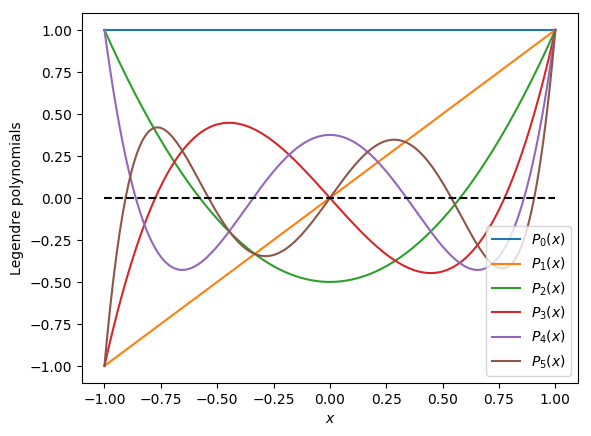

PyObject <matplotlib.text.Text object at 0x325271510>

In [12]:
leg = []
x = linspace(-1, 1, 300)
for i in eachindex(L)
    plot(x, L[i].(x), "-")
    push!(leg, "\$P_{$(i-1)}(x)\$")
end
plot(x, 0*x, "k--")
legend(leg)
xlabel(L"x")
ylabel("Legendre polynomials")

Note that $p_n(x)$ has exactly $n$ roots in the interval $[-1,1]$!

### Expanding a polynomial in the Legendre basis.

Now that we have an orthogonal (but not orthonormal) basis, it is easy to take an arbitrary polynomial $p(x)$ and write it in this basis:

$$
    p(x) = \alpha_0 p_0(x) + \alpha_1 p_1(x) + \cdots = \sum_{i=0}^\infty \alpha_i p_i(x)
$$

because we can get the coefficients $\alpha_i$ merely by projecting:

$$
\alpha_i = \frac{p_i \cdot p}{p_i \cdot p_i}
$$

Note, however, that this isn't actually an infinite series: if the polynomial $p(x)$ has degree $d$, then $\alpha_i = 0$ for $i > d$.  The polynomials $p_0, \ldots, p_d$ are a basis for the subspace of polynomials of degree $d$ (= span of $1, x, \ldots, x^d$)!

Let's see how this works for a "randomly" chosen $p(x)$ of degree 5:

In [13]:
p = Poly([1,3,4,7,2,5])

Poly(1 + 3⋅x + 4⋅x^2 + 7⋅x^3 + 2⋅x^4 + 5⋅x^5)

Here are the coefficients α:

In [14]:
α = [polydot(q,p)/polydot(q,q) for q in L]

6-element Array{Rational{Int64},1}:
  41//15
 327//35
  80//21
 226//45
  16//35
  40//63

Let's check that the sum of $\alpha_i p_i(x)$ gives $p(x)$:

In [15]:
sum(α .* L) # α[1]*L[1] + α[2]*L[2] + ... + α[6]*L[6]

Poly(1//1 + 3//1⋅x + 4//1⋅x^2 + 7//1⋅x^3 + 2//1⋅x^4 + 5//1⋅x^5)

In [16]:
sum(α .* L) - p

Poly(0//1)